In [1]:
import MDAnalysis as mda
import numpy as np
import nglview as nv
import matplotlib.pyplot as plt

# Uncomment for interactive widget functionality: zooming, panning, additional information when hovering over cells.
#%matplotlib widget

In [2]:
u = mda.Universe("data/6xdc.pdb") # SARS-CoV2 ORF3a

/home/dot/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/PDB.py:429: UserWarning: 1 A^3 CRYST1 record, this is usually a placeholder. Unit cell dimensions will be set to None.
  warnings.warn("1 A^3 CRYST1 record,"


In [4]:
# Importing, aligning, filtering

import aligner as al

s_raw, *_ = al.utilities.read_fasta_file("./data/P0DTC3.fasta") # P0DTC3: SARS-CoV-2 ORF3a
t_raw, *_ = al.utilities.read_fasta_file("./data/P59632.fasta") # P59632: SARS-CoV ORF3a

s = al.utilities._str_str_to_FastaEntry(s_raw)
t = al.utilities._str_str_to_FastaEntry(t_raw)

a = al.aligner.Aligner(s, t)

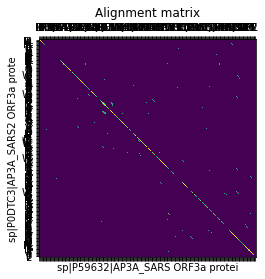

In [5]:
a.construct_windowed_alignment_matrix()
a.plot_alignment_matrix()

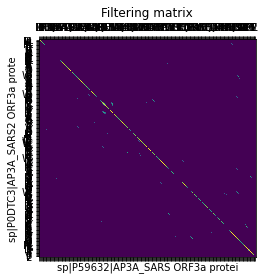

In [6]:
a.addition_pass()
a.plot_filter_matrix()

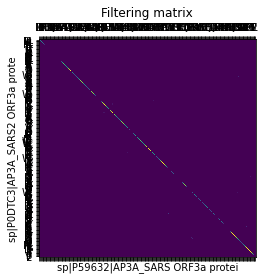

In [7]:
a.shortening_pass()
a.plot_filter_matrix()

In [8]:
a.long_substrings_report()

Comparing
	s:  275	sp|P0DTC3|AP3A_SARS2 ORF3a protein OS=Severe acute respiratory syndrome coronavirus 2 OX=2697049 GN=3a PE=1 SV=1
	t:  274	sp|P59632|AP3A_SARS ORF3a protein OS=Severe acute respiratory syndrome coronavirus OX=694009 GN=3a PE=1 SV=1
Done, completed in 0.004 seconds
	start     	end       	len 
	——————————	——————————	————
	(117, 117)	(163, 163)	  47
s:  INFVRIIMRLWLCWKCRSKNPLLYDANYFLCWHTNCYDYCIPYNSVT
    ||  ||||| |||||| |||||||||||| ||||  |||||||||||
t:  INACRIIMRCWLCWKCKSKNPLLYDANYFVCWHTHNYDYCIPYNSVT
	(27, 27)  	(72, 72)  	  46
s:  FVRATATIPIQASLPFGWLIVGVALLAVFQSASKIITLKKRWQLAL
     | |||||| |||||||||  ||| ||||||| ||| | |||||||
t:  TVHATATIPLQASLPFGWLVIGVAFLAVFQSATKIIALNKRWQLAL
	(77, 77)  	(115, 115)	  39
s:  HFVCNLLLLFVTVYSHLLLVAAGLEAPFLYLYALVYFLQ
     | ||||||||| |||||||||| || ||||||| ||||
t:  QFICNLLLLFVTIYSHLLLVAAGMEAQFLYLYALIYFLQ
	(240, 241)	(271, 272)	  32
s:  EHVQIHTIDGSSGVVNPVMEPIYDEPTTTTSV
      |||||||||||| || | ||||||||||||
t:  PNVQIHTIDGSSGVANPAMDPIYDEPTTTT

In [9]:
def create_color_list(d, offset, color_func): 
    return [[color_func(d, pos), str(pos + offset)] for pos in range(0, len(d))]

from matplotlib import cm, colors

def viridis(d, i): 
    mapped = np.interp(d[i], [d.min(), d.max()], [0., 1.]) # map value onto [0, 1]
    cmap = cm.get_cmap('viridis')
    rgba = cmap(mapped)
    return colors.to_hex(rgba)

def determine_colorscheme_offset(universe, component: str) -> int:
    return universe.select_atoms(f"segid {component}").residues.resnums[0]

In [10]:
# A fun colorful colorscheme I used while figuring out how to use 
# ColormakerRegistry.
d = a.filtering_matrix.diagonal()

nv.color.ColormakerRegistry.add_selection_scheme(
    "coolors", create_color_list(range(0, 1000), 0, lambda _, n: f"#{n * 50000:06x}")
)

In [11]:
# Create a custom color scheme based on the sequence alignments I make.
offset = determine_colorscheme_offset(u, 'A')
alignment_color_list = create_color_list(d, offset, viridis)

nv.color.ColormakerRegistry.add_selection_scheme(
    "alignment", alignment_color_list
)


In [12]:
view = nv.show_mdanalysis(u.atoms, default_representation=False)
view.add_representation("cartoon", ":A", color_scheme="alignment")
view.add_representation("cartoon", ":B", color_scheme="alignment", opacity=0.4440154, gui=True)
view.center()
#view.display(gui=True)
view

NGLWidget()

## Investigating intrinsically disordered domains

Zhou, J., Oldfield, C. J., Yan, W., Shen, B., & Dunker, A. K. (2019). Intrinsically disordered domains: Sequence ➔ disorder ➔ function relationships. _Protein science : a publication of the Protein Society_, 28(9), 1652–1663. https://doi.org/10.1002/pro.3680

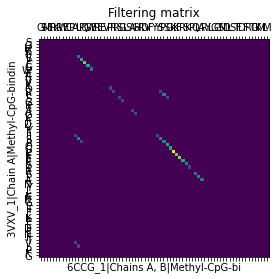

In [13]:
# Fetch fastas from RCSB PDB
# 3VXV: methyl CpG Binding Domain of MBD4 in complex with the 5mCG/TG sequence
ordered_pdb = "3VXV"
# 6CCG: MBD3 MBD domain in complex with methylated CpG DNA
disordered_pdb = "6CCG"
ord_seq, *_ = al.utilities.get_rcsb_pdb_fasta(ordered_pdb)
disord_seq, *_ = al.utilities.get_rcsb_pdb_fasta(disordered_pdb)

# Alignment
a = al.aligner.Aligner(ord_seq, disord_seq)
a.construct_windowed_alignment_matrix()
a.squaring_pass()
a.addition_pass()
a.plot_filter_matrix()

In [14]:
vertical_diag_offset = 0
horizontal_diag_offset = 7
diag = a.filtering_matrix[vertical_diag_offset:,horizontal_diag_offset:].diagonal()
diag, len(diag)

(array([ 0,  0,  0,  0,  0, 16, 25, 32, 25, 16,  0,  0,  0,  0,  0,  9,  9,
         0,  9,  9,  0,  0,  9,  9,  0,  0,  0,  0,  0,  0,  9, 18, 18, 25,
        25, 41, 32, 34, 25, 18,  9,  0, 16, 18, 16,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       dtype=int16),
 66)

In [15]:
# "First, you must invent the universe."
ordered = mda.Universe(f"data/{disordered_pdb}.pdb")
disordered = mda.Universe(f"data/{ordered_pdb}.pdb")
#both = mda.Merge(ordered.atoms, disordered.atoms)

/home/dot/.local/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:334: UserWarning: Unknown element X found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/home/dot/.local/lib/python3.10/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: X
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


In [16]:
offset = determine_colorscheme_offset(ordered, 'A') + horizontal_diag_offset
nv.color.ColormakerRegistry.add_selection_scheme(
    "order_alignment", create_color_list(diag, offset, viridis)
)

ord_view = nv.show_mdanalysis(ordered.atoms, default_representation=False)
ord_view.add_representation("cartoon", ":A", color_scheme="order_alignment")
ord_view.center()
ord_view

NGLWidget()

In [17]:
offset = determine_colorscheme_offset(disordered, 'A') + vertical_diag_offset 
nv.color.ColormakerRegistry.add_selection_scheme(
    "disorder_alignment", create_color_list(diag, offset, viridis)
)

disord_view = nv.show_mdanalysis(disordered.atoms, default_representation=False)
disord_view.add_representation("cartoon", ":A", color_scheme="disorder_alignment")
disord_view.center()
disord_view

NGLWidget()

## Taking a look at the horizontal and vertical sums

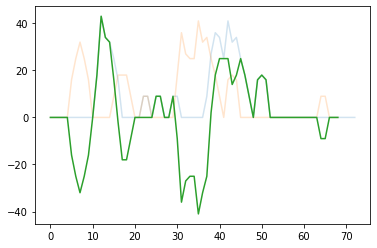

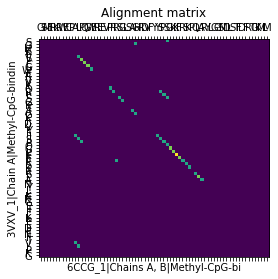

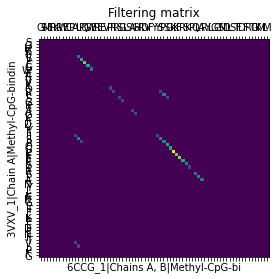

In [19]:
horizontal = a.filtering_matrix.sum(axis=0)
vertical = a.filtering_matrix.sum(axis=1)
plt.plot(horizontal, alpha=0.2)
plt.plot(vertical, alpha=0.2)
min_len = min(len(horizontal), len(vertical))
delta = horizontal[:min_len] - vertical[:min_len]
plt.plot(delta)
plt.show()
a.plot_alignment_matrix()
a.plot_filter_matrix()

In [20]:
print("Thank you :)")

Thank you :)
